---
# 1. 라이브러리 불러오기
---

In [1]:
import librosa # 음원 데이터 분석 라이브러리 
import librosa.display as dsp
from IPython.display import Audio # 음원을 파이썬 작업환경에서 띄우는 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader 
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn 
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # GPU 할당

---
# 2. 데이터 불러오기
----

In [2]:
path = '/content/drive/MyDrive/2. Study/Audio_Study/train/'
sample = os.listdir(path)

train = pd.DataFrame(columns = ['file_name'])

for i in sample:
  value = os.listdir(path + str(i))
  df = pd.DataFrame(value, columns = ['file_name'])
  train = pd.concat([train, df], axis = 0)

train = train.reset_index(drop = True)
# label 생성
train['label'] = None
for i in range(len(train)):
  train['label'][i] = train['file_name'][i][0]  

train['label'] = train['label'].astype(int)
train


,file_name,label
0,0_01_33.wav,0
1,0_01_15.wav,0
2,0_01_1.wav,0
3,0_01_23.wav,0
4,0_01_18.wav,0
...,...,...
3765,4_08_35.wav,4
3766,1_08_47.wav,1
3767,4_08_30.wav,4
3768,4_08_8.wav,4


In [3]:
for i in os.listdir(path + '01')[:3]:
  print(f'{i}')
  data, sample_rate = librosa.load(path + '01/' + str(i), sr=20000)
  print('sample_rate:', sample_rate, ', audio shape:', data.shape)
  print('length:', data.shape[0]/float(sample_rate), 'secs')
  print('\n')

0_01_33.wav
sample_rate: 20000 , audio shape: (11855,)
length: 0.59275 secs


0_01_15.wav
sample_rate: 20000 , audio shape: (13803,)
length: 0.69015 secs


0_01_1.wav
sample_rate: 20000 , audio shape: (13065,)
length: 0.65325 secs




---
# 3. Audio Data Feature 추출
---

In [4]:
def make_dataset(path):
  sample = os.listdir(path)
  dataset = []
  for i in tqdm(sample):
    root = path + i
    data, sample_rate = librosa.load(root, sr = 20000)
    dataset.append([data,i[0]])
  return pd.DataFrame(dataset, columns = ['data','label'])

In [5]:
train_feature = pd.DataFrame()
for i in sample:
  a = make_dataset(path + f'{i}/')
  train_feature = pd.concat([train_feature, a])

train_feature = train_feature.reset_index(drop = True)
train_feature['label'] = train_feature['label'].astype(int)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

In [6]:
train_feature = train_feature.sample(frac = 1).reset_index(drop = True)
train_feature

,data,label
0,"[0.00033343153, -0.00037106074, 0.00026702063,...",5
1,"[0.00040852383, 0.00058226526, 0.00046224022, ...",0
2,"[-0.00018274924, -0.0002969084, -0.00020771987...",4
3,"[0.0006547378, 0.0010214733, 0.0008735414, 0.0...",2
4,"[-0.00024840585, -0.0004137575, -0.00034579964...",8
...,...,...
3765,"[4.276342e-05, 7.3523115e-05, 7.253859e-05, 5....",4
3766,"[-0.00050878635, -0.0007834599, -0.0006227024,...",2
3767,"[-4.5160203e-05, -6.8527705e-05, -4.915145e-05...",6
3768,"[4.9187665e-06, 7.217354e-05, 3.9484792e-05, 2...",9


---
### 3-1. Padding
---

In [7]:
feature_data = train_feature.data
label = train_feature.label

오디오들의 길이가 같지 않기때문에 melspectrogram과 mfcc 모두 길이가 제각각

여유로운 크기의 고정 사이즈를 정하고

고정사이즈에 맞추어 랜덤으로 앞이나 뒤에 padding을 실시

각각 파일마다 데시벨의 차이가 있을 것이라 생각하고 파일마다 min_max_scale 실시

In [8]:
def random_pad(mels, pad_size, mfcc=True):

  pad_width = pad_size - mels.shape[1]
  rand = np.random.rand()
  left = int(pad_width * rand)
  right = pad_width - left
  
  if mfcc:
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
  else:
    local_max, local_min = mels.max(), mels.min()
    mels = (mels - local_min)/(local_max - local_min)
    mels = np.pad(mels, pad_width=((0,0), (left, right)), mode='constant')


  return mels

size = 40
pad_size = 40 # 정사각형이 되도록 40으로 설정 
repeat_size = 5  
sr = 20000

In [9]:
audio_mels = []
audio_mfcc = []

for y in feature_data:
  mels = librosa.feature.melspectrogram(y, sr=sr, n_mels=size)
  mels = librosa.power_to_db(mels, ref=np.max)

  mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=size)
  
  for i in range(repeat_size):
    audio_mels.append(random_pad(mels, pad_size=pad_size, mfcc=False))
    audio_mfcc.append(random_pad(mfcc, pad_size=pad_size, mfcc=True))

In [10]:
# 타겟값 복제
target = np.repeat(label,repeat_size)
target = target.reset_index(drop = True)

# array 변환
audio_mels_array = np.array(audio_mels, np.float64)
audio_mfcc_array = np.array(audio_mfcc, np.float64)

<ipython-input-11-745ea4573954>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(4, 4, i + 1)


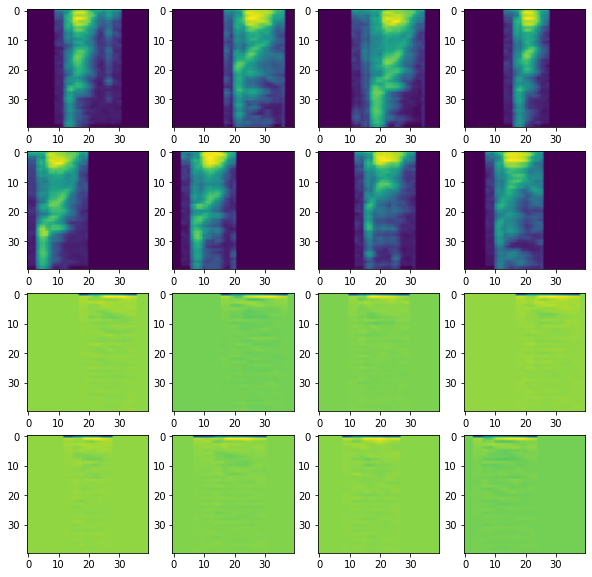

In [11]:
target_num = 2
target_num_idx = np.where(target==target_num)[0]
target_num_idx = np.random.choice(target_num_idx,16)

plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)

for i, idx in enumerate(target_num_idx):
  ax = plt.subplot(4, 4, i + 1)
  if i<8:
    plt.imshow(audio_mels_array[idx], aspect='auto')
  else:
    plt.imshow(audio_mfcc_array[idx], aspect='auto')

In [12]:
audio_mels_array = audio_mels_array.reshape(-1, audio_mels_array.shape[1], audio_mels_array.shape[2], 1)
audio_mfcc_array = audio_mfcc_array.reshape(-1, audio_mfcc_array.shape[1], audio_mfcc_array.shape[2], 1)

print(target.shape)
print(audio_mels_array.shape)
print(audio_mfcc_array.shape)
print(type(audio_mels_array))
print(type(audio_mfcc_array))
print(type(target))

(18850,)
(18850, 40, 40, 1)
(18850, 40, 40, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


----
# 4. dataset
----

In [13]:
class custom_dataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype = torch.float32)
    self.y = torch.tensor(y)
  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]
    return x,y
  def __len__(self):
    return len(self.x)

---
# 5. Model
----

In [14]:
class Model_mel(nn.Module):

  def __init__(self):
    super(Model_mel,self).__init__()
    self.layer1 = nn.Sequential(
                        nn.Conv2d(40,10, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2), # pooling
                        )

    self.layer2 = nn.Sequential(
                        nn.Conv2d(10,50, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer3 = nn.Sequential(
                        nn.Conv2d(50,100, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer4 = nn.Sequential(
                        nn.Conv2d(100,200, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )
    self.fc_layer = nn.Sequential(
                        nn.Linear(600,10)
                        )

    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)  
    x = torch.flatten(x, start_dim = 1) # N차원 배열에서 1차원 배열로 변환
    out = self.fc_layer(x)
    return out

In [15]:
class Model_mfcc(nn.Module):

  def __init__(self):
    super(Model_mfcc,self).__init__()
    self.layer1 = nn.Sequential(
                        nn.Conv2d(40,100, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2), # pooling
                        )

    self.layer2 = nn.Sequential(
                        nn.Conv2d(100,200, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer3 = nn.Sequential(
                        nn.Conv2d(200,400, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )

    self.layer4 = nn.Sequential(
                        nn.Conv2d(400,600, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )
    self.layer5 = nn.Sequential(
                        nn.Conv2d(600,300, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )
    self.layer6 = nn.Sequential(
                        nn.Conv2d(300,150, kernel_size = 2, stride = 1, padding = 1), # cnn
                        nn.ReLU(), # active function
                        nn.MaxPool2d(kernel_size = 2, stride = 2) # pooling
                        )        
    self.fc_layer = nn.Sequential(
                        nn.Linear(150,10)
                        )

    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)  
    x = self.layer5(x)  
    x = self.layer6(x)  
    x = torch.flatten(x, start_dim = 1) # N차원 배열에서 1차원 배열로 변환
    out = self.fc_layer(x)
    return out

---
# 6. Train
----

In [16]:
# 에포크 설정
num_epochs_mel = 10
num_epochs_mfcc = 40

In [17]:
def Train_code(train_mel_loader, model, optimizer, total_loss, Accuracy, num_epoch, name:str, criterion, device):
  model.train()
  for epoch, (data, label) in enumerate(tqdm(train_mel_loader)):
    data = data.to(device)
    label = label.to(device)

    # predict
    logits = model(data)
    pred = logits.argmax(1, keepdim = True)

    # loss
    loss = criterion(logits, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    # Accuracy += pred.eq(label.view_as(pred)).sum().item() 
  # print(f'Train_{name}: {num_epoch + 1} loss: {round(total_loss / len(train_mel_loader),5)} Accuracy:{round((Accuracy / len(train_mel_loader.dataset)),4)}')
  print(f'Train_{name}: {num_epoch + 1} loss: {round(total_loss / len(train_mel_loader),5)}')

In [18]:
def Test_code(train_mel_loader, model, optimizer, total_loss, Accuracy, path, fold, num_epoch, name:str, criterion, device):
  model.eval()
  with torch.no_grad():
    for epoch, (data, label) in enumerate(tqdm(train_mel_loader)):
      data = data.to(device)
      label = label.to(device)

      # predict
      logits = model(data)
      pred = logits.argmax(1, keepdim = True)

      # loss
      loss = criterion(logits, label)

      total_loss += loss.item()
      Accuracy += pred.eq(label.view_as(pred)).sum().item()
    acc_value = round((Accuracy / len(train_mel_loader.dataset)),4)
    print(f'Test_{name} : {num_epoch + 1} loss: {round(total_loss / len(train_mel_loader),5)} Accuracy: {acc_value}')
    return total_loss, acc_value

In [19]:
def ensemble_code(train_mel_loader, model, log_list,  device):
  model.eval()
  with torch.no_grad():
    for epoch, (data, label) in enumerate(tqdm(train_mel_loader)):
      data = data.to(device)
      label = label.to(device)

      # predict
      logits = model(data)
      log_list.append(logits)
    return log_list

In [20]:
batch_size = 32

final_acc = {}

skf = StratifiedKFold(n_splits=5)

for fold,(train_index, val_index) in enumerate(skf.split(audio_mels_array, target)):

  print(f'\n********** {fold+1} fold **********')
  ensemble = []
  mel_log = []
  mfcc_log = []

  ################ MEL ################
  train_x_mel, val_x_mel, train_y_mel, val_y_mel = audio_mels_array[train_index], audio_mels_array[val_index], target[train_index], target[val_index]
  ################ MEL ################
  train_x_mfcc, val_x_mfcc, train_y_mfcc, val_y_mfcc = audio_mfcc_array[train_index], audio_mfcc_array[val_index], target[train_index], target[val_index]

  ##### np.ndarray 변환 #####
  train_y_mel = np.array(train_y_mel)
  val_y_mel = np.array(val_y_mel)
      ##### mfcc #####
  train_y_mfcc = np.array(train_y_mfcc)
  val_y_mfcc = np.array(val_y_mfcc)

  ############# dataset & data_loader #############
  train_mel = custom_dataset(x=train_x_mel, y=train_y_mel)
  train_mel_loader = DataLoader(train_mel, batch_size = batch_size, shuffle=True, drop_last = True)
  val_mel = custom_dataset(x=val_x_mel, y=val_y_mel)
  val_mel_loader = DataLoader(val_mel, batch_size = batch_size, shuffle=False, drop_last = True)
    ##### mfcc #####
  train_mfcc = custom_dataset(x=train_x_mfcc, y=train_y_mfcc)
  train_mfcc_loader = DataLoader(train_mfcc, batch_size = batch_size, shuffle=True, drop_last = True)
  val_mfcc = custom_dataset(x=val_x_mfcc, y=val_y_mfcc)
  val_mfcc_loader = DataLoader(val_mfcc, batch_size = batch_size, shuffle=False, drop_last = True)

  ########### model & optimizer ###########
  model_mel = Model_mel().to(device)
  model_mfcc = Model_mfcc().to(device)
  optimizer_mel = torch.optim.Adam(params = model_mel.parameters(), lr = 1e-4 )
  optimizer_mfcc = torch.optim.Adam(params = model_mfcc.parameters(), lr = 1e-4 )
  criterion_mel = torch.nn.CrossEntropyLoss().to(device)
  criterion_mfcc = torch.nn.CrossEntropyLoss().to(device)

  ############## Log ##############
  total_train_loss_mel = 0
  Accuracy_train_mel = 0
  total_test_loss_mel = 0
  Accuracy_test_mel = 0
  
  total_train_loss_mfcc = 0
  Accuracy_train_mfcc = 0
  total_test_loss_mfcc = 0
  Accuracy_test_mfcc = 0
  
  value_mel = 0
  value_mfcc = 0
  path = '/content/drive/MyDrive/2. Study/Audio_Study/model_save/'
  
  fold_acc = {}
  for num_epoch in range(num_epochs_mel):
    
    ############ mel ############
    Train_code(train_mel_loader, model_mel, optimizer_mel, total_train_loss_mel, Accuracy_train_mel, num_epoch, 'mel_epoch', criterion_mel, device)
    
    mel_loss, mel_acc = Test_code(val_mel_loader, model_mel, optimizer_mel, total_test_loss_mel, Accuracy_test_mel, path, fold, num_epoch, 'mel_epoch', criterion_mel, device)

    
    ######### Best_Score_Save #########
    if mel_acc > value_mel:
      value_mel = mel_acc
      torch.save(model_mel.state_dict(), path + f'model_mel_fold_{fold + 1}.pt')
      fold_acc[f'mel_Acc_{fold+1}'] = value_mel

  print('#' * 50)
  

  for num_epoch2 in range(num_epochs_mfcc):
    ############ mfcc ############
    Train_code(train_mfcc_loader, model_mfcc, optimizer_mfcc, total_train_loss_mfcc, Accuracy_train_mfcc, num_epoch2, 'mfcc_epoch', criterion_mfcc, device)
    
    mfcc_loss, mfcc_acc = Test_code(val_mfcc_loader, model_mfcc, optimizer_mfcc, total_test_loss_mfcc, Accuracy_test_mfcc, path, fold, num_epoch2, 'mfcc_epoch', criterion_mfcc, device)

    ######### Best_Score_Save #########
    if mfcc_acc > value_mfcc:
      value_mfcc = mfcc_acc
      torch.save(model_mfcc.state_dict(), path + f'model_mfcc_fold_{fold + 1}.pt')
      fold_acc[f'mfcc_Acc_{fold+1}'] = value_mfcc
  print('#' * 50)
  
  ######### Best_model_load #########
  model_mel.load_state_dict(torch.load(path + f'model_mel_fold_{fold + 1}.pt'))
  mel_logits = ensemble_code(val_mel_loader, model_mel, mel_log,  device)
  model_mfcc.load_state_dict(torch.load(path + f'model_mfcc_fold_{fold + 1}.pt'))
  mfcc_logits = ensemble_code(val_mfcc_loader, model_mfcc, mfcc_log,  device)

  ########## ensemble_Accuracy ##########
  for i in range(len(val_mfcc_loader)):
    ensemble.append(mel_logits[i] + mfcc_logits[i])

  ensemble = torch.stack(ensemble)

  ensemble_acc = 0
  for epoch, (_, label) in enumerate(tqdm(val_mfcc_loader)):
    label = label.to(device)
    pred = ensemble[epoch].argmax(1, keepdim = True)
    ensemble_acc += pred.eq(label.view_as(pred)).sum().item()
  acc_value = round((ensemble_acc / len(val_mfcc_loader.dataset)),4)
  fold_acc[f'ensemble_ACC_{fold + 1}'] = acc_value

  final_acc[f'fold_{fold+1}'] = fold_acc
  print(acc_value)  


********** 1 fold **********


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 1 loss: 1.86725


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 1 loss: 0.98431 Accuracy: 0.6666


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 2 loss: 0.7778


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 2 loss: 0.6527 Accuracy: 0.782


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 3 loss: 0.53764


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 3 loss: 0.4817 Accuracy: 0.8432


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 4 loss: 0.39829


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 4 loss: 0.36649 Accuracy: 0.8822


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 5 loss: 0.3183


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 5 loss: 0.3223 Accuracy: 0.8905


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 6 loss: 0.2656


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 6 loss: 0.26429 Accuracy: 0.9122


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 7 loss: 0.22634


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 7 loss: 0.2406 Accuracy: 0.9172


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 8 loss: 0.20172


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 8 loss: 0.20792 Accuracy: 0.9292


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 9 loss: 0.18045


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 9 loss: 0.19251 Accuracy: 0.9313


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 10 loss: 0.16103


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 10 loss: 0.18719 Accuracy: 0.9321
##################################################


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 1 loss: 2.30193


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 1 loss: 2.30127 Accuracy: 0.0995


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 2 loss: 2.30025


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 2 loss: 2.30094 Accuracy: 0.1061


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 3 loss: 1.93304


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 3 loss: 1.76927 Accuracy: 0.3042


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 4 loss: 1.5883


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 4 loss: 1.47089 Accuracy: 0.4318


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 5 loss: 1.3116


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 5 loss: 1.1144 Accuracy: 0.5867


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 6 loss: 1.0265


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 6 loss: 1.03277 Accuracy: 0.6045


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 7 loss: 0.86964


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 7 loss: 0.7695 Accuracy: 0.7053


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 8 loss: 0.80015


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 8 loss: 0.72804 Accuracy: 0.7233


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 9 loss: 0.69189


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 9 loss: 0.67427 Accuracy: 0.7393


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 10 loss: 0.64735


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 10 loss: 0.73497 Accuracy: 0.717


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 11 loss: 0.58019


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 11 loss: 0.54529 Accuracy: 0.7836


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 12 loss: 0.561


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 12 loss: 0.53088 Accuracy: 0.808


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 13 loss: 0.53208


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 13 loss: 0.51925 Accuracy: 0.8117


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 14 loss: 0.48986


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 14 loss: 0.45401 Accuracy: 0.8302


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 15 loss: 0.45118


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 15 loss: 0.54081 Accuracy: 0.7955


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 16 loss: 0.40716


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 16 loss: 0.42943 Accuracy: 0.8472


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 17 loss: 0.38256


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 17 loss: 0.54642 Accuracy: 0.7873


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 18 loss: 0.36149


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 18 loss: 0.35303 Accuracy: 0.8735


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 19 loss: 0.3394


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 19 loss: 0.44142 Accuracy: 0.8414


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 20 loss: 0.29732


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 20 loss: 0.27685 Accuracy: 0.9011


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 21 loss: 0.29072


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 21 loss: 0.35946 Accuracy: 0.8647


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 22 loss: 0.25575


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 22 loss: 0.24099 Accuracy: 0.9202


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 23 loss: 0.23995


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 23 loss: 0.29769 Accuracy: 0.8918


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 24 loss: 0.23775


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 24 loss: 0.26529 Accuracy: 0.8992


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 25 loss: 0.21611


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 25 loss: 0.22396 Accuracy: 0.9218


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 26 loss: 0.19825


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 26 loss: 0.19501 Accuracy: 0.9276


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 27 loss: 0.18148


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 27 loss: 0.18795 Accuracy: 0.9329


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 28 loss: 0.16679


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 28 loss: 0.54354 Accuracy: 0.809


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 29 loss: 0.16423


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 29 loss: 0.22107 Accuracy: 0.9149


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 30 loss: 0.15145


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 30 loss: 0.16565 Accuracy: 0.935


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 31 loss: 0.13207


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 31 loss: 0.25987 Accuracy: 0.9048


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 32 loss: 0.12562


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 32 loss: 0.14054 Accuracy: 0.9496


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 33 loss: 0.10885


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 33 loss: 0.13555 Accuracy: 0.9488


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 34 loss: 0.15568


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 34 loss: 0.29742 Accuracy: 0.8905


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 35 loss: 0.09052


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 35 loss: 0.11147 Accuracy: 0.957


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 36 loss: 0.10402


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 36 loss: 0.14005 Accuracy: 0.9493


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 37 loss: 0.0968


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 37 loss: 0.22052 Accuracy: 0.921


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 38 loss: 0.08506


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 38 loss: 0.20237 Accuracy: 0.9249


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 39 loss: 0.07803


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 39 loss: 0.08831 Accuracy: 0.9637


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 40 loss: 0.07455


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 40 loss: 0.09141 Accuracy: 0.9621
##################################################


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

0.9775

********** 2 fold **********


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 1 loss: 1.9484


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 1 loss: 1.14635 Accuracy: 0.5963


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 2 loss: 0.88541


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 2 loss: 0.73244 Accuracy: 0.7501


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 3 loss: 0.60852


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 3 loss: 0.54522 Accuracy: 0.8212


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 4 loss: 0.45355


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 4 loss: 0.43747 Accuracy: 0.8515


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 5 loss: 0.35089


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 5 loss: 0.35047 Accuracy: 0.8838


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 6 loss: 0.28336


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 6 loss: 0.31315 Accuracy: 0.892


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 7 loss: 0.23824


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 7 loss: 0.26244 Accuracy: 0.9146


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 8 loss: 0.20694


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 8 loss: 0.23216 Accuracy: 0.917


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 9 loss: 0.18178


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 9 loss: 0.21542 Accuracy: 0.9223


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 10 loss: 0.15967


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 10 loss: 0.19505 Accuracy: 0.9271
##################################################


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 1 loss: 2.29508


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 1 loss: 2.25934 Accuracy: 0.148


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 2 loss: 2.05122


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 2 loss: 1.96865 Accuracy: 0.221


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 3 loss: 1.88159


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 3 loss: 1.84158 Accuracy: 0.2592


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 4 loss: 1.69068


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 4 loss: 1.71572 Accuracy: 0.3438


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 5 loss: 1.34689


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 5 loss: 1.15713 Accuracy: 0.6053


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 6 loss: 0.96959


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 6 loss: 0.92425 Accuracy: 0.6554


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 7 loss: 0.71046


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 7 loss: 0.6227 Accuracy: 0.7875


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 8 loss: 0.5721


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 8 loss: 0.53664 Accuracy: 0.8199


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 9 loss: 0.49286


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 9 loss: 0.42996 Accuracy: 0.8472


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 10 loss: 0.42347


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 10 loss: 0.42622 Accuracy: 0.8401


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 11 loss: 0.38644


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 11 loss: 0.35203 Accuracy: 0.8716


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 12 loss: 0.34081


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 12 loss: 0.41754 Accuracy: 0.8369


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 13 loss: 0.31356


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 13 loss: 0.40112 Accuracy: 0.8549


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 14 loss: 0.27326


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 14 loss: 0.72487 Accuracy: 0.7385


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 15 loss: 0.25422


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 15 loss: 0.26117 Accuracy: 0.9058


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 16 loss: 0.24251


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 16 loss: 0.23526 Accuracy: 0.9119


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 17 loss: 0.2071


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 17 loss: 0.21803 Accuracy: 0.9122


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 18 loss: 0.21218


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 18 loss: 0.18723 Accuracy: 0.9284


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 19 loss: 0.18499


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 19 loss: 0.19757 Accuracy: 0.9225


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 20 loss: 0.15956


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 20 loss: 0.16111 Accuracy: 0.9393


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 21 loss: 0.20854


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 21 loss: 0.19407 Accuracy: 0.9326


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 22 loss: 0.14174


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 22 loss: 0.18991 Accuracy: 0.9244


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 23 loss: 0.12554


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 23 loss: 0.16739 Accuracy: 0.9387


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 24 loss: 0.12767


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 24 loss: 0.24553 Accuracy: 0.9114


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 25 loss: 0.11484


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 25 loss: 0.1705 Accuracy: 0.9374


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 26 loss: 0.1148


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 26 loss: 0.13898 Accuracy: 0.9462


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 27 loss: 0.11625


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 27 loss: 0.26566 Accuracy: 0.9074


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 28 loss: 0.1182


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 28 loss: 0.14199 Accuracy: 0.9459


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 29 loss: 0.09468


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 29 loss: 0.11181 Accuracy: 0.9549


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 30 loss: 0.10425


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 30 loss: 0.10796 Accuracy: 0.9605


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 31 loss: 0.08501


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 31 loss: 0.08487 Accuracy: 0.9676


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 32 loss: 0.08023


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 32 loss: 0.11145 Accuracy: 0.9576


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 33 loss: 0.08629


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 33 loss: 0.10592 Accuracy: 0.9602


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 34 loss: 0.09328


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 34 loss: 0.11729 Accuracy: 0.9554


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 35 loss: 0.05283


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 35 loss: 0.10844 Accuracy: 0.9607


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 36 loss: 0.05915


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 36 loss: 0.07801 Accuracy: 0.9687


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 37 loss: 0.06841


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 37 loss: 0.13125 Accuracy: 0.9499


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 38 loss: 0.05381


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 38 loss: 0.08102 Accuracy: 0.9637


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 39 loss: 0.0578


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 39 loss: 0.07846 Accuracy: 0.9714


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 40 loss: 0.05476


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 40 loss: 0.08066 Accuracy: 0.9671
##################################################


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

0.9759

********** 3 fold **********


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 1 loss: 1.75542


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 1 loss: 0.86745 Accuracy: 0.7037


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 2 loss: 0.69928


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 2 loss: 0.58146 Accuracy: 0.8034


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 3 loss: 0.49813


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 3 loss: 0.4174 Accuracy: 0.8615


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 4 loss: 0.38698


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 4 loss: 0.33799 Accuracy: 0.8891


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 5 loss: 0.31734


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 5 loss: 0.29156 Accuracy: 0.8987


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 6 loss: 0.27036


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 6 loss: 0.23948 Accuracy: 0.9186


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 7 loss: 0.23064


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 7 loss: 0.21247 Accuracy: 0.9276


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 8 loss: 0.20388


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 8 loss: 0.20938 Accuracy: 0.9231


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 9 loss: 0.1813


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 9 loss: 0.16766 Accuracy: 0.9379


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 10 loss: 0.16326


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 10 loss: 0.15016 Accuracy: 0.9517
##################################################


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 1 loss: 2.30244


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 1 loss: 2.30055 Accuracy: 0.1061


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 2 loss: 2.29931


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 2 loss: 2.27981 Accuracy: 0.1103


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 3 loss: 2.08036


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 3 loss: 1.99735 Accuracy: 0.2159


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 4 loss: 1.83131


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 4 loss: 1.72186 Accuracy: 0.3748


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 5 loss: 1.48253


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 5 loss: 1.34185 Accuracy: 0.4732


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 6 loss: 1.28987


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 6 loss: 1.39794 Accuracy: 0.4642


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 7 loss: 1.147


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 7 loss: 1.14789 Accuracy: 0.5706


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 8 loss: 0.99026


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 8 loss: 0.86138 Accuracy: 0.6963


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 9 loss: 0.78414


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 9 loss: 0.68745 Accuracy: 0.7655


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 10 loss: 0.64652


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 10 loss: 0.59079 Accuracy: 0.7905


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 11 loss: 0.5171


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 11 loss: 0.67191 Accuracy: 0.7459


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 12 loss: 0.46536


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 12 loss: 0.4115 Accuracy: 0.8629


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 13 loss: 0.43208


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 13 loss: 0.41499 Accuracy: 0.8424


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 14 loss: 0.36142


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 14 loss: 0.54656 Accuracy: 0.7944


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 15 loss: 0.31632


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 15 loss: 0.27927 Accuracy: 0.9008


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 16 loss: 0.29174


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 16 loss: 0.32026 Accuracy: 0.8865


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 17 loss: 0.27272


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 17 loss: 0.29839 Accuracy: 0.8862


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 18 loss: 0.25345


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 18 loss: 0.43283 Accuracy: 0.8361


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 19 loss: 0.24352


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 19 loss: 0.28312 Accuracy: 0.8979


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 20 loss: 0.23087


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 20 loss: 0.21209 Accuracy: 0.9294


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 21 loss: 0.20196


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 21 loss: 0.19604 Accuracy: 0.9305


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 22 loss: 0.1869


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 22 loss: 0.22929 Accuracy: 0.9175


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 23 loss: 0.19892


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 23 loss: 0.19588 Accuracy: 0.9302


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 24 loss: 0.17565


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 24 loss: 0.21764 Accuracy: 0.9215


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 25 loss: 0.16426


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 25 loss: 0.17079 Accuracy: 0.9385


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 26 loss: 0.15869


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 26 loss: 0.2505 Accuracy: 0.9122


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 27 loss: 0.14273


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 27 loss: 0.17723 Accuracy: 0.9337


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 28 loss: 0.12527


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 28 loss: 0.12632 Accuracy: 0.9552


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 29 loss: 0.15311


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 29 loss: 0.13334 Accuracy: 0.9538


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 30 loss: 0.12531


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 30 loss: 0.11543 Accuracy: 0.9602


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 31 loss: 0.1054


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 31 loss: 0.18675 Accuracy: 0.9337


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 32 loss: 0.11057


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 32 loss: 0.10742 Accuracy: 0.961


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 33 loss: 0.10362


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 33 loss: 0.09914 Accuracy: 0.9653


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 34 loss: 0.0955


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 34 loss: 0.10451 Accuracy: 0.9634


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 35 loss: 0.09947


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 35 loss: 0.1155 Accuracy: 0.9557


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 36 loss: 0.08252


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 36 loss: 0.12616 Accuracy: 0.9576


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 37 loss: 0.09267


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 37 loss: 0.08255 Accuracy: 0.9679


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 38 loss: 0.10387


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 38 loss: 0.09091 Accuracy: 0.9631


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 39 loss: 0.06558


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 39 loss: 0.09366 Accuracy: 0.9645


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 40 loss: 0.06953


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 40 loss: 0.08608 Accuracy: 0.9655
##################################################


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

0.9796

********** 4 fold **********


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 1 loss: 1.87014


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 1 loss: 0.98787 Accuracy: 0.6854


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 2 loss: 0.78152


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 2 loss: 0.63141 Accuracy: 0.7902


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 3 loss: 0.53434


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 3 loss: 0.44684 Accuracy: 0.8525


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 4 loss: 0.38775


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 4 loss: 0.33544 Accuracy: 0.8844


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 5 loss: 0.29675


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 5 loss: 0.26434 Accuracy: 0.9066


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 6 loss: 0.23775


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 6 loss: 0.2277 Accuracy: 0.9183


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 7 loss: 0.19869


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 7 loss: 0.19535 Accuracy: 0.9268


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 8 loss: 0.16829


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 8 loss: 0.16777 Accuracy: 0.9366


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 9 loss: 0.14602


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 9 loss: 0.14451 Accuracy: 0.948


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 10 loss: 0.12813


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 10 loss: 0.1317 Accuracy: 0.9491
##################################################


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 1 loss: 2.30125


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 1 loss: 2.30068 Accuracy: 0.1061


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 2 loss: 1.9866


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 2 loss: 1.71944 Accuracy: 0.3019


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 3 loss: 1.7189


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 3 loss: 1.5971 Accuracy: 0.3557


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 4 loss: 1.61232


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 4 loss: 1.57983 Accuracy: 0.3878


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 5 loss: 1.47673


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 5 loss: 1.38335 Accuracy: 0.4822


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 6 loss: 1.24508


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 6 loss: 1.05617 Accuracy: 0.591


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 7 loss: 1.02649


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 7 loss: 0.84206 Accuracy: 0.692


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 8 loss: 0.84971


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 8 loss: 0.70649 Accuracy: 0.7477


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 9 loss: 0.76579


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 9 loss: 0.69357 Accuracy: 0.7401


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 10 loss: 0.6845


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 10 loss: 0.98301 Accuracy: 0.6337


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 11 loss: 0.59568


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 11 loss: 0.57723 Accuracy: 0.783


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 12 loss: 0.5761


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 12 loss: 0.5045 Accuracy: 0.8194


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 13 loss: 0.50923


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 13 loss: 0.45262 Accuracy: 0.8432


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 14 loss: 0.47005


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 14 loss: 0.4346 Accuracy: 0.8488


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 15 loss: 0.45529


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 15 loss: 0.46233 Accuracy: 0.8379


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 16 loss: 0.4199


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 16 loss: 0.37156 Accuracy: 0.8708


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 17 loss: 0.37232


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 17 loss: 0.35885 Accuracy: 0.8796


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 18 loss: 0.38837


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 18 loss: 0.33304 Accuracy: 0.895


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 19 loss: 0.38498


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 19 loss: 0.33994 Accuracy: 0.878


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 20 loss: 0.32168


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 20 loss: 0.28338 Accuracy: 0.9088


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 21 loss: 0.32042


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 21 loss: 0.26304 Accuracy: 0.909


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 22 loss: 0.34576


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 22 loss: 0.26631 Accuracy: 0.9138


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 23 loss: 0.28286


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 23 loss: 0.23706 Accuracy: 0.9207


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 24 loss: 0.26493


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 24 loss: 0.23245 Accuracy: 0.9263


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 25 loss: 0.2419


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 25 loss: 0.21534 Accuracy: 0.9239


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 26 loss: 0.23447


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 26 loss: 0.24951 Accuracy: 0.9138


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 27 loss: 0.25569


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 27 loss: 0.3245 Accuracy: 0.8751


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 28 loss: 0.20388


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 28 loss: 0.28956 Accuracy: 0.8862


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 29 loss: 0.18544


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 29 loss: 0.18582 Accuracy: 0.9355


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 30 loss: 0.16907


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 30 loss: 0.13904 Accuracy: 0.9504


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 31 loss: 0.15


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 31 loss: 0.14633 Accuracy: 0.9472


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 32 loss: 0.16517


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 32 loss: 0.16764 Accuracy: 0.9411


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 33 loss: 0.13789


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 33 loss: 0.1605 Accuracy: 0.9374


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 34 loss: 0.14014


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 34 loss: 0.19476 Accuracy: 0.9294


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 35 loss: 0.10097


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 35 loss: 0.11539 Accuracy: 0.9533


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 36 loss: 0.11017


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 36 loss: 0.23078 Accuracy: 0.9135


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 37 loss: 0.13321


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 37 loss: 0.11053 Accuracy: 0.9512


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 38 loss: 0.12328


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 38 loss: 0.09149 Accuracy: 0.9682


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 39 loss: 0.07309


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 39 loss: 0.07366 Accuracy: 0.9737


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 40 loss: 0.08643


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 40 loss: 0.08018 Accuracy: 0.9645
##################################################


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

0.9812

********** 5 fold **********


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 1 loss: 1.91291


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 1 loss: 1.04762 Accuracy: 0.6241


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 2 loss: 0.79425


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 2 loss: 0.62931 Accuracy: 0.7846


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 3 loss: 0.54379


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 3 loss: 0.48979 Accuracy: 0.8199


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 4 loss: 0.41108


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 4 loss: 0.34328 Accuracy: 0.8782


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 5 loss: 0.32513


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 5 loss: 0.28075 Accuracy: 0.896


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 6 loss: 0.26245


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 6 loss: 0.25102 Accuracy: 0.904


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 7 loss: 0.22138


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 7 loss: 0.20111 Accuracy: 0.9241


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 8 loss: 0.19115


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 8 loss: 0.17894 Accuracy: 0.9279


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 9 loss: 0.16393


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 9 loss: 0.16056 Accuracy: 0.939


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mel_epoch: 10 loss: 0.14862


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mel_epoch : 10 loss: 0.1383 Accuracy: 0.9485
##################################################


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 1 loss: 2.30337


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 1 loss: 2.30179 Accuracy: 0.1034


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 2 loss: 2.25829


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 2 loss: 2.12528 Accuracy: 0.1618


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 3 loss: 1.78574


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 3 loss: 1.62141 Accuracy: 0.3573


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 4 loss: 1.6227


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 4 loss: 1.47715 Accuracy: 0.4581


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 5 loss: 1.38469


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 5 loss: 1.1734 Accuracy: 0.5552


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 6 loss: 1.18521


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 6 loss: 1.0081 Accuracy: 0.6125


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 7 loss: 1.02448


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 7 loss: 0.95893 Accuracy: 0.6281


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 8 loss: 0.90941


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 8 loss: 1.03323 Accuracy: 0.5859


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 9 loss: 0.79327


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 9 loss: 0.68095 Accuracy: 0.7584


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 10 loss: 0.71907


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 10 loss: 0.77861 Accuracy: 0.6814


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 11 loss: 0.65092


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 11 loss: 0.80188 Accuracy: 0.6976


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 12 loss: 0.58089


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 12 loss: 0.50836 Accuracy: 0.8162


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 13 loss: 0.52408


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 13 loss: 0.47395 Accuracy: 0.8294


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 14 loss: 0.50648


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 14 loss: 0.41597 Accuracy: 0.8615


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 15 loss: 0.42667


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 15 loss: 0.36397 Accuracy: 0.8748


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 16 loss: 0.4054


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 16 loss: 0.3617 Accuracy: 0.8634


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 17 loss: 0.38818


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 17 loss: 0.38914 Accuracy: 0.8586


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 18 loss: 0.35145


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 18 loss: 0.32502 Accuracy: 0.8899


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 19 loss: 0.33064


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 19 loss: 0.2895 Accuracy: 0.8989


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 20 loss: 0.29708


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 20 loss: 0.25929 Accuracy: 0.9114


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 21 loss: 0.30252


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 21 loss: 0.26329 Accuracy: 0.9024


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 22 loss: 0.30659


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 22 loss: 0.29288 Accuracy: 0.8958


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 23 loss: 0.23835


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 23 loss: 0.51598 Accuracy: 0.813


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 24 loss: 0.23188


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 24 loss: 0.25651 Accuracy: 0.9111


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 25 loss: 0.23028


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 25 loss: 0.18974 Accuracy: 0.9318


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 26 loss: 0.19692


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 26 loss: 0.2646 Accuracy: 0.9016


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 27 loss: 0.19576


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 27 loss: 0.25875 Accuracy: 0.8944


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 28 loss: 0.18059


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 28 loss: 0.14159 Accuracy: 0.9448


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 29 loss: 0.20656


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 29 loss: 0.13728 Accuracy: 0.9469


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 30 loss: 0.14576


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 30 loss: 0.12844 Accuracy: 0.9501


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 31 loss: 0.15382


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 31 loss: 0.24717 Accuracy: 0.9045


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 32 loss: 0.14448


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 32 loss: 0.15353 Accuracy: 0.9414


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 33 loss: 0.14663


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 33 loss: 0.14401 Accuracy: 0.943


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 34 loss: 0.10469


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 34 loss: 0.08921 Accuracy: 0.9626


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 35 loss: 0.10598


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 35 loss: 0.15372 Accuracy: 0.939


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 36 loss: 0.10962


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 36 loss: 0.33794 Accuracy: 0.8743


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 37 loss: 0.1035


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 37 loss: 0.08044 Accuracy: 0.966


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 38 loss: 0.09733


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 38 loss: 0.08738 Accuracy: 0.966


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 39 loss: 0.0804


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 39 loss: 0.09034 Accuracy: 0.9674


  0%|          | 0/471 [00:00<?, ?it/s]

Train_mfcc_epoch: 40 loss: 0.09249


  0%|          | 0/117 [00:00<?, ?it/s]

Test_mfcc_epoch : 40 loss: 0.12797 Accuracy: 0.9552
##################################################


  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

0.9756


In [23]:
final_acc

{'fold_1': {'mel_Acc_1': 0.9321,
  'mfcc_Acc_1': 0.9637,
  'ensemble_ACC_1': 0.9775},
 'fold_2': {'mel_Acc_2': 0.9271,
  'mfcc_Acc_2': 0.9714,
  'ensemble_ACC_2': 0.9759},
 'fold_3': {'mel_Acc_3': 0.9517,
  'mfcc_Acc_3': 0.9679,
  'ensemble_ACC_3': 0.9796},
 'fold_4': {'mel_Acc_4': 0.9491,
  'mfcc_Acc_4': 0.9737,
  'ensemble_ACC_4': 0.9812},
 'fold_5': {'mel_Acc_5': 0.9485,
  'mfcc_Acc_5': 0.9674,
  'ensemble_ACC_5': 0.9756}}

In [22]:
key_list = final_acc.keys()
for i in key_list:
  print(final_acc[i])
  print()

{'mel_Acc_1': 0.9321, 'mfcc_Acc_1': 0.9637, 'ensemble_ACC_1': 0.9775}

{'mel_Acc_2': 0.9271, 'mfcc_Acc_2': 0.9714, 'ensemble_ACC_2': 0.9759}

{'mel_Acc_3': 0.9517, 'mfcc_Acc_3': 0.9679, 'ensemble_ACC_3': 0.9796}

{'mel_Acc_4': 0.9491, 'mfcc_Acc_4': 0.9737, 'ensemble_ACC_4': 0.9812}

{'mel_Acc_5': 0.9485, 'mfcc_Acc_5': 0.9674, 'ensemble_ACC_5': 0.9756}

